Retrieved 138 patents from PatentsView.


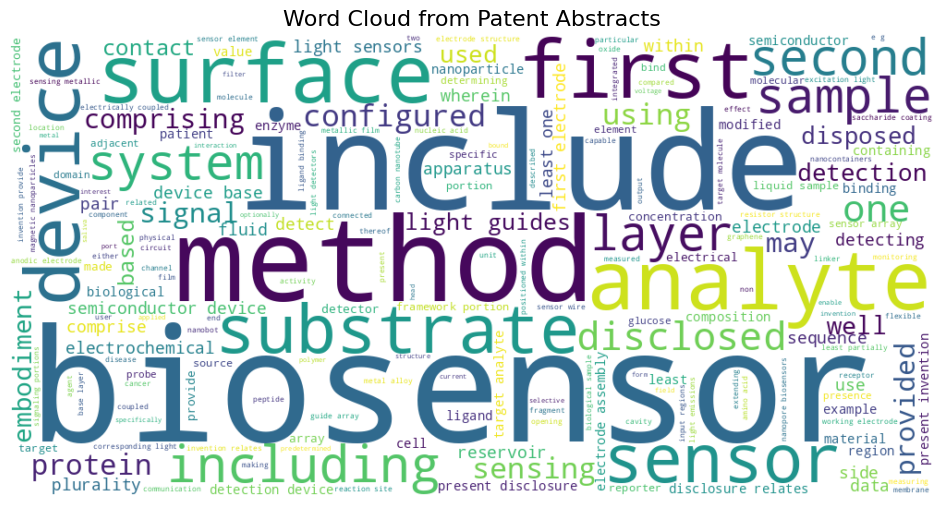

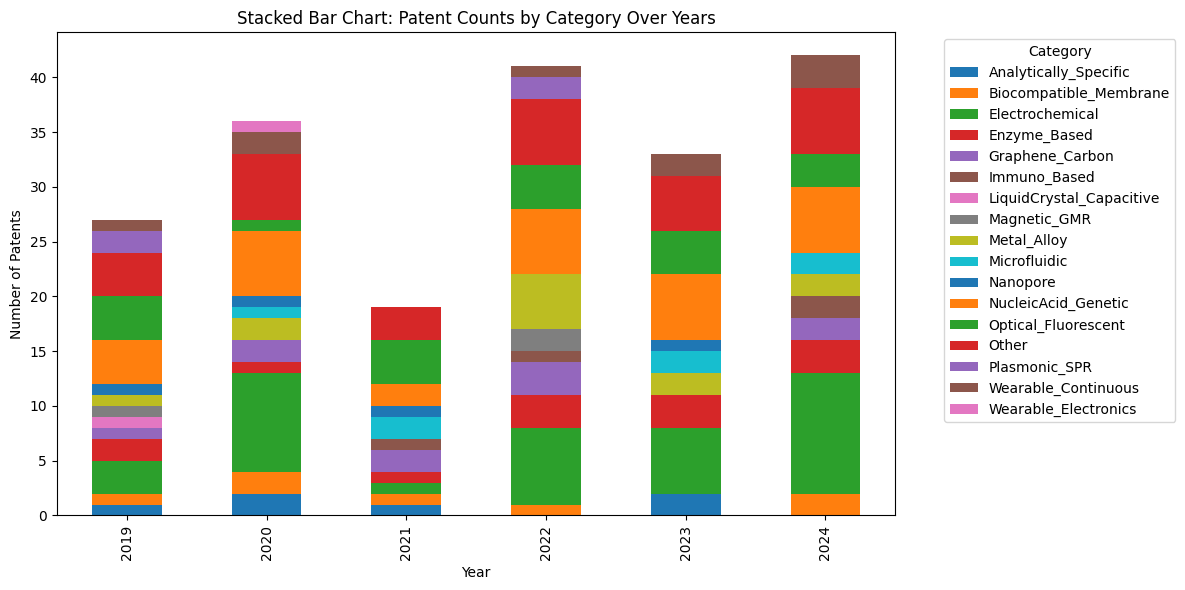

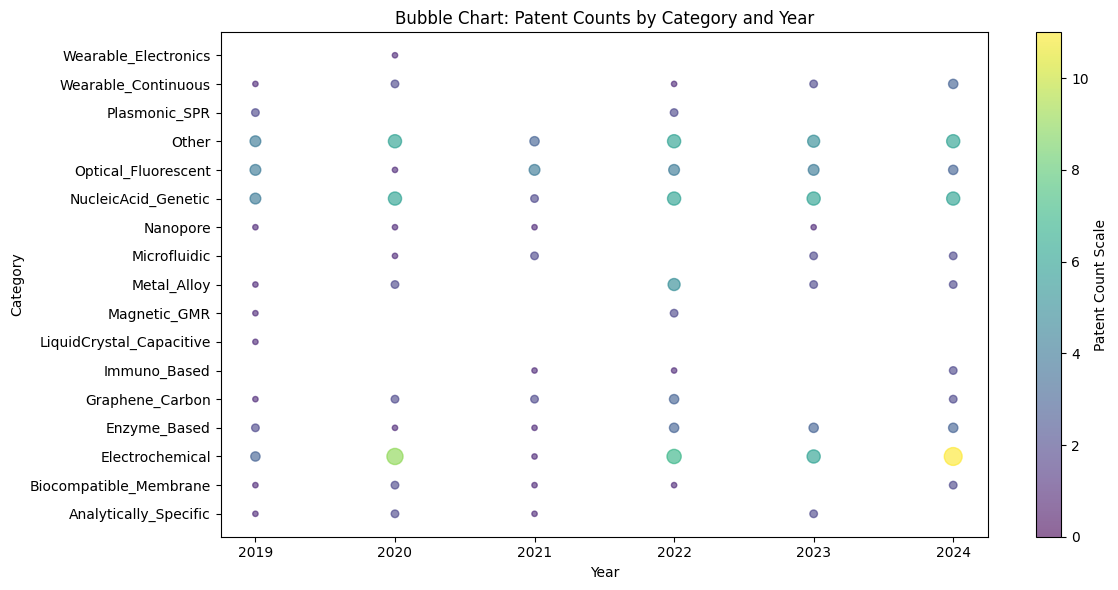

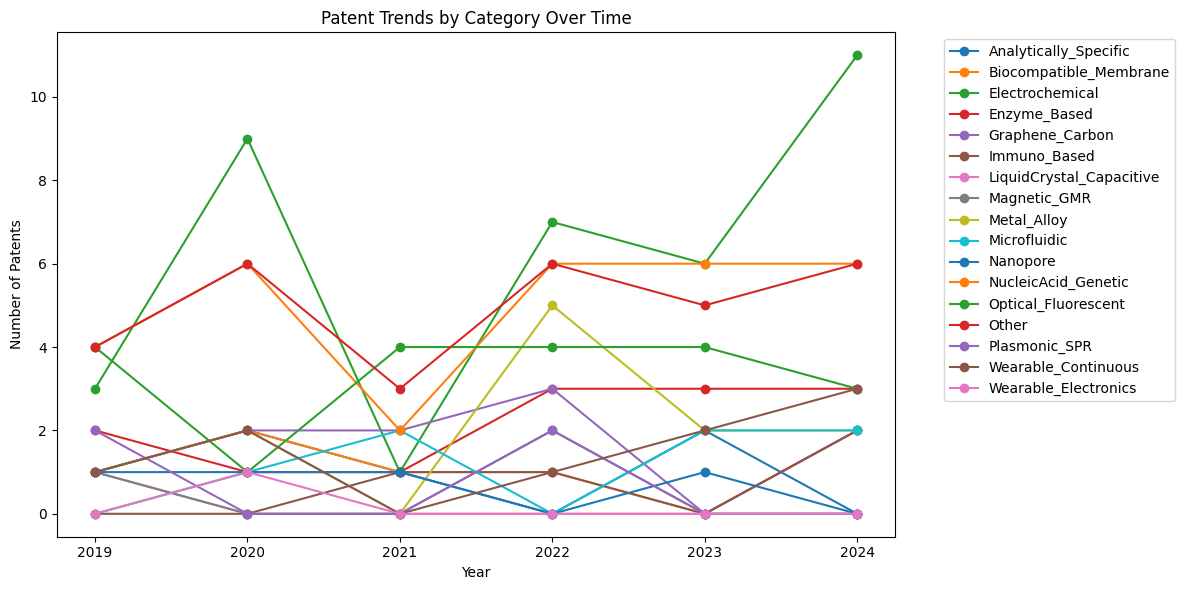

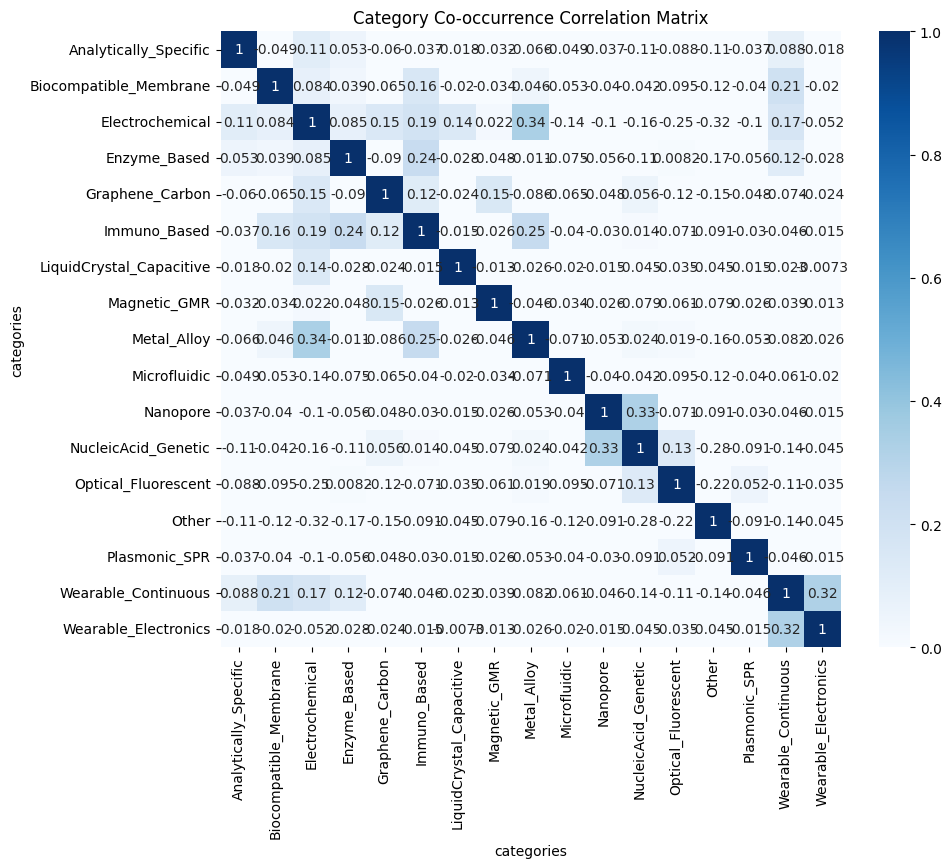

No references data loaded, skipping citation network.
No assignee data loaded, skipping assignee analysis.
Mega script execution completed.


In [1]:
#!/usr/bin/env python3
"""
Mega Script for Biosensor Patent Analysis
-----------------------------------------
1. Query PatentsView for biosensor patents
2. Classify patents into categories
3. Explode the categories and visualize:
   - Stacked bar chart (patents per year by category)
   - Bubble chart (patents by category vs year)
   - Line chart (trend lines for categories)
   - Category co-occurrence analysis (heatmap)
4. (Optional) Integrate references data to build citation networks
5. (Optional) Integrate assignee data for organizational or geographic analysis
"""

import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import seaborn as sns

# -------------------------------------------------------------------------
# PART 1: Query the PatentsView API
# -------------------------------------------------------------------------

def query_patentsview():
    """
    Query the PatentsView API for biosensor patents after 2019-01-01
    and return a DataFrame with key fields.
    """
    api_url = "https://api.patentsview.org/patents/query"
    payload = {
        "q": {
            "_and": [
                {"_text_any": {"patent_title": "biosensors"}},
                {"_gte": {"patent_date": "2019-01-01"}}
            ]
        },
        "f": [
            "patent_number",
            "patent_title",
            "patent_date",
            "patent_abstract"
        ],
        "o": {
            "page": 1,
            "per_page": 200  # Adjust as needed or implement pagination
        }
    }

    response = requests.post(api_url, json=payload)
    if response.status_code == 200:
        data = response.json()
        patents = data.get("patents", [])
        df = pd.DataFrame(patents)
        # Convert patent_date to datetime
        if not df.empty:
            df['patent_date'] = pd.to_datetime(df['patent_date'])
        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        return pd.DataFrame()  # Return empty if error

# -------------------------------------------------------------------------
# PART 2: (Optional) Load Additional Data (References, Assignees, Inventors)
# -------------------------------------------------------------------------
# These functions demonstrate how you might load or query additional data.
# In practice, you'd replace the stubs with actual logic to query or merge.

def load_references_data():
    """
    Placeholder for references data.
    Suppose we have a CSV or a separate API call that returns references:
    Columns might be: [patent_number, cited_patent_number]
    """
    # For demonstration, return an empty DataFrame
    return pd.DataFrame(columns=["patent_number", "cited_patent_number"])

def load_assignee_data():
    """
    Placeholder for assignee or inventor data.
    Suppose we have a CSV or a separate API call that returns info:
    Columns might be: [patent_number, assignee_organization, inventor_country, etc.]
    """
    # For demonstration, return an empty DataFrame
    return pd.DataFrame(columns=["patent_number", "assignee_organization", "inventor_country"])

# -------------------------------------------------------------------------
# PART 3: Classification
# -------------------------------------------------------------------------
# 1) We define an expanded dictionary of categories and keywords
# 2) Classify each patent by searching for keywords in the title + abstract

CATEGORY_KEYWORDS = {
    "Electrochemical": [
        r"electrochemical", r"electrode", r"amperometric", r"voltamm", r"potentiometric",
        r"impedimetric", r"enzymatic sensor", r"biofuel cell", r"oect"
    ],
    "Optical_Fluorescent": [
        r"optical", r"fluoresc", r"photon", r"f\u00f6rster resonance energy transfer", r"\bfret\b",
        r"bret", r"chemiluminescence", r"label[- ]?free detection", r"fluorogenic", r"fluorophore"
    ],
    "Plasmonic_SPR": [
        r"plasmonic", r"surface plasmon resonance", r"\bspr\b", r"raman", r"sers"
    ],
    "Graphene_Carbon": [
        r"graphene", r"graphene oxide", r"reduced graphene oxide", r"carbon nanotube",
        r"carbon electrode", r"cnt"
    ],
    "Nanopore": [
        r"nanopore", r"cytolysin", r"pore[- ]?based"
    ],
    "NucleicAcid_Genetic": [
        r"dna", r"rna", r"nucleic acid", r"aptamer", r"crispr", r"ligase", r"genetically encoded",
        r"transcription factor", r"polyketide", r"polynucleotide"
    ],
    "Immuno_Based": [
        r"immuno", r"antibody", r"immunoassay", r"immunosensor", r"elisa", r"antigen"
    ],
    "Enzyme_Based": [
        r"enzyme", r"oxidase", r"kinase", r"tyrosine kinase", r"glucose oxidase",
        r"urease", r"lactate oxidase", r"amylase"
    ],
    "Wearable_Continuous": [
        r"wearable", r"on[- ]?body", r"skin patch", r"continuous monitoring", r"epidermal",
        r"non-invasive", r"iontophoretic"
    ],
    "Microfluidic": [
        r"microfluidic", r"microchannel", r"flow cell"
    ],
    "Magnetic_GMR": [
        r"magnetic nanoparticle", r"magnetoresistance", r"\bgmr\b", r"magnetic spectroscopy"
    ],
    "LiquidCrystal_Capacitive": [
        r"liquid crystal", r"lc sensor", r"capacitive", r"capacitance"
    ],
    "Metal_Alloy": [
        r"nickel alloy", r"ruthenium alloy", r"metal alloy", r"platinum", r"gold electrode",
        r"mn2o3", r"metal oxide"
    ],
    "Wearable_Electronics": [
        r"smart glasses", r"electronic glasses", r"biosensor glasses", r"headset"
    ],
    "Biocompatible_Membrane": [
        r"membrane", r"hydrogel", r"biocompatible layer", r"polymer film", r"organosilicon"
    ],
    "Analytically_Specific": [
        r"glucose sensor", r"cholesterol", r"oxidized ldl", r"ldl", r"urea sensor", r"calcium sensor",
        r"chloride", r"nitrate", r"bicarbonate", r"lactate"
    ],
    # Catch-all fallback
    "Other": []
}

def classify_patent(title, abstract):
    """
    Return a list of matching categories based on keywords in title+abstract.
    """
    text = (title + " " + abstract).lower() if abstract else title.lower()
    matched_cats = []
    for cat, patterns in CATEGORY_KEYWORDS.items():
        if cat == "Other":
            continue  # We'll assign "Other" if nothing else matches
        for pattern in patterns:
            if re.search(pattern, text):
                matched_cats.append(cat)
                break  # Found a match for this category, move to next
    return matched_cats if matched_cats else ["Other"]

# -------------------------------------------------------------------------
# PART 4: Main Execution: Query + Classification + Visualizations
# -------------------------------------------------------------------------

def main():
    # 1) Query the PatentsView API
    df = query_patentsview()
    if df.empty:
        print("No data retrieved. Exiting.")
        return

    print(f"Retrieved {len(df)} patents from PatentsView.")

    # 2) (Optional) Load additional data: references, assignee, etc.
    df_references = load_references_data()
    df_assignees = load_assignee_data()

    # 3) Classify patents into categories
    df['abstract'] = df['patent_abstract'].fillna("")  # handle missing abstracts
    df['categories'] = df.apply(
        lambda row: classify_patent(row['patent_title'], row['abstract']),
        axis=1
    )

    # 4) Explode categories for counting
    df_exploded = df.explode('categories').reset_index(drop=True)

    # 5) Word Cloud
    all_abstracts = " ".join(df['abstract'].tolist())
    wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(all_abstracts)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud from Patent Abstracts", fontsize=16)
    plt.show()

    # 6) Basic Count by Year
    df_exploded['year'] = df_exploded['patent_date'].dt.year
    # Create pivot: rows = years, columns = categories, values = count
    pivot_table = df_exploded.pivot_table(
        index='year',
        columns='categories',
        values='patent_number',
        aggfunc='count',
        fill_value=0
    )

    # ---------------------------------------------------------------------
    # Visualization A: Stacked Bar Chart (Category vs Year)
    # ---------------------------------------------------------------------
    pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.xlabel("Year")
    plt.ylabel("Number of Patents")
    plt.title("Stacked Bar Chart: Patent Counts by Category Over Years")
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------------------
    # Visualization B: Bubble Chart (Category vs Year)
    # ---------------------------------------------------------------------
    long_df = pivot_table.reset_index().melt(id_vars="year", var_name="category", value_name="count")
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        long_df['year'],
        long_df['category'],
        s=long_df['count']*15,  # bubble size scale factor
        c=long_df['count'],
        alpha=0.6,
        cmap='viridis'
    )
    plt.colorbar(scatter, label="Patent Count Scale")
    plt.xlabel("Year")
    plt.ylabel("Category")
    plt.title("Bubble Chart: Patent Counts by Category and Year")
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------------------
    # Visualization C: Line Chart for Each Category (Trends)
    # ---------------------------------------------------------------------
    plt.figure(figsize=(12, 6))
    for cat in pivot_table.columns:
        plt.plot(pivot_table.index, pivot_table[cat], marker='o', label=cat)
    plt.title("Patent Trends by Category Over Time")
    plt.xlabel("Year")
    plt.ylabel("Number of Patents")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------------------
    # PART 5: Category Co-occurrence Analysis
    # ---------------------------------------------------------------------
    # Build a wide-format DataFrame: 1 row per patent_number, 1 col per category
    # Cell = 1 if that patent has that category, else 0
    patent_category_matrix = (
        df_exploded
        .assign(value=1)
        .pivot_table(index='patent_number', columns='categories', values='value', fill_value=0)
    )

    # Compute correlation matrix among categories
    corr_matrix = patent_category_matrix.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=0, vmax=1)
    plt.title("Category Co-occurrence Correlation Matrix")
    plt.show()

    # ---------------------------------------------------------------------
    # PART 6: (Optional) References / Citation Network
    # ---------------------------------------------------------------------
    if not df_references.empty:
        import networkx as nx

        # Suppose df_references has columns: patent_number, cited_patent_number
        G = nx.DiGraph()
        for _, row in df_references.iterrows():
            citing = row['patent_number']
            cited = row['cited_patent_number']
            G.add_node(citing)
            G.add_node(cited)
            G.add_edge(citing, cited)

        # Compute in-degree to find most-cited patents
        in_degs = dict(G.in_degree())
        most_cited = sorted(in_degs.items(), key=lambda x: x[1], reverse=True)
        print("Top 10 most-cited patents:")
        for patent, deg in most_cited[:10]:
            print(patent, deg)

        # (Optional) visualize for smaller graphs
        # nx.draw(G, with_labels=False, node_size=10)
        # plt.show()
    else:
        print("No references data loaded, skipping citation network.")

    # ---------------------------------------------------------------------
    # PART 7: (Optional) Assignee/Inventor Analysis
    # ---------------------------------------------------------------------
    if not df_assignees.empty:
        # Merge with df_exploded on 'patent_number' if needed
        df_merged = pd.merge(df_exploded, df_assignees, on='patent_number', how='left')

        # Example: Count how many patents each assignee filed per year
        if 'assignee_organization' in df_merged.columns:
            group = df_merged.groupby(['assignee_organization', 'year']).size().reset_index(name='count')
            # Print top 10
            print("Top 10 assignees by patent count (any year):")
            print(group.sort_values('count', ascending=False).head(10))

            # You could pivot for a heatmap
            pivot_assignee = group.pivot(index='assignee_organization', columns='year', values='count').fillna(0)
            plt.figure(figsize=(12, 10))
            sns.heatmap(pivot_assignee, annot=True, cmap='YlGnBu')
            plt.title("Patents by Assignee Organization and Year")
            plt.show()
        else:
            print("No 'assignee_organization' field available.")
    else:
        print("No assignee data loaded, skipping assignee analysis.")

    print("Mega script execution completed.")

# -------------------------------------------------------------------------
# Run main if this script is executed directly
# -------------------------------------------------------------------------
if __name__ == "__main__":
    main()


In [2]:
import requests
import pandas as pd
import json

# -------------------------------------------------------------------
# Step 1: Query PatentsView with Additional Fields Using "include" for Nested Data
# -------------------------------------------------------------------
api_url = "https://api.patentsview.org/patents/query"

payload = {
    "q": {
        "_and": [
            {"_text_any": {"patent_title": "biosensors"}},
            {"_gte": {"patent_date": "2019-01-01"}}
        ]
    },
    "f": [
        "patent_number",
        "patent_title",
        "patent_date",
        "patent_abstract",
        "inventor_first_name",
        "inventor_last_name",
        "inventor_country",
        "assignee_organization"
    ],
    "o": {
        "page": 1,
        "per_page": 200,
        "include": ["inventors", "assignees"]  # Request nested inventor & assignee data
    }
}

response = requests.post(api_url, json=payload)
if response.status_code == 200:
    data = response.json()
    patents = data.get("patents", [])
    print(f"Retrieved {len(patents)} patents from PatentsView.")
else:
    print("Error fetching data:", response.status_code)
    try:
        print(response.json())
    except Exception as e:
        print("Error parsing response:", e)
    patents = []

# -------------------------------------------------------------------
# Step 2: Convert Main Data to a DataFrame (df_main)
# -------------------------------------------------------------------
df_main = pd.DataFrame(patents)
if not df_main.empty:
    df_main['patent_date'] = pd.to_datetime(df_main['patent_date'])
else:
    print("No patent data retrieved.")

# -------------------------------------------------------------------
# Step 3: Extract Nested Inventor Data into df_inventors
# -------------------------------------------------------------------
inventor_records = []
for patent in patents:
    pn = patent.get("patent_number")
    # The PatentsView API returns nested inventor data in a key named "inventors"
    inventors = patent.get("inventors", [])
    for inv in inventors:
        inventor_records.append({
            "patent_number": pn,
            "inventor_first_name": inv.get("inventor_first_name", ""),
            "inventor_last_name": inv.get("inventor_last_name", ""),
            "inventor_country": inv.get("inventor_country", "")
        })

df_inventors = pd.DataFrame(inventor_records)

# -------------------------------------------------------------------
# Step 4: Extract Nested Assignee Data into df_assignees
# -------------------------------------------------------------------
assignee_records = []
for patent in patents:
    pn = patent.get("patent_number")
    # The API returns nested assignee data in a key named "assignees"
    assignees = patent.get("assignees", [])
    for assignee in assignees:
        assignee_records.append({
            "patent_number": pn,
            "assignee_organization": assignee.get("assignee_organization", "")
        })

df_assignees = pd.DataFrame(assignee_records)

# -------------------------------------------------------------------
# Print summaries for confirmation
# -------------------------------------------------------------------
print("\n--- Summary of Retrieved Data ---")
print("Main Data (df_main):", df_main.shape)
print("Inventor Data (df_inventors):", df_inventors.shape)
print("Assignee Data (df_assignees):", df_assignees.shape)

if not df_main.empty:
    print("\ndf_main sample:")
    print(df_main[['patent_number', 'patent_title', 'patent_date']].head())
else:
    print("df_main is empty.")

print("\ndf_inventors sample:")
print(df_inventors.head())

print("\ndf_assignees sample:")
print(df_assignees.head())


Retrieved 138 patents from PatentsView.

--- Summary of Retrieved Data ---
Main Data (df_main): (138, 6)
Inventor Data (df_inventors): (478, 4)
Assignee Data (df_assignees): (150, 2)

df_main sample:
  patent_number                                       patent_title patent_date
0      10190100  Chemical modification of glucose oxidase and i...  2019-01-29
1      10190154            Reduced graphene oxide-based biosensors  2019-01-29
2      10202466              Linked peptide fluorogenic biosensors  2019-02-12
3      10241110  Plasmonic biosensors with built-in artificial ...  2019-03-26
4      10254225  Biosensors for biological or chemical analysis...  2019-04-09

df_inventors sample:
  patent_number inventor_first_name inventor_last_name inventor_country
0      10190100            Cindy X.               Zhou               US
1      10190100              Zenghe                Liu               US
2      10190154              Yingfu                 Li               CA
3      10190154 

In [1]:
import pandas as pd

# Assuming df_main, df_inventors, and df_assignees are already defined

# Extract shapes
main_shape = df_main.shape  # (138, 6)
inventor_shape = df_inventors.shape  # (478, 4)
assignee_shape = df_assignees.shape  # (150, 2)

# Create a summary DataFrame
summary_data = {
    "Data Type": ["Main Data", "Inventor Data", "Assignee Data"],
    "Number of Records": [main_shape[0], inventor_shape[0], assignee_shape[0]],
    "Number of Fields": [main_shape[1], inventor_shape[1], assignee_shape[1]]
}

df_summary = pd.DataFrame(summary_data)

print(df_summary)


NameError: name 'df_main' is not defined

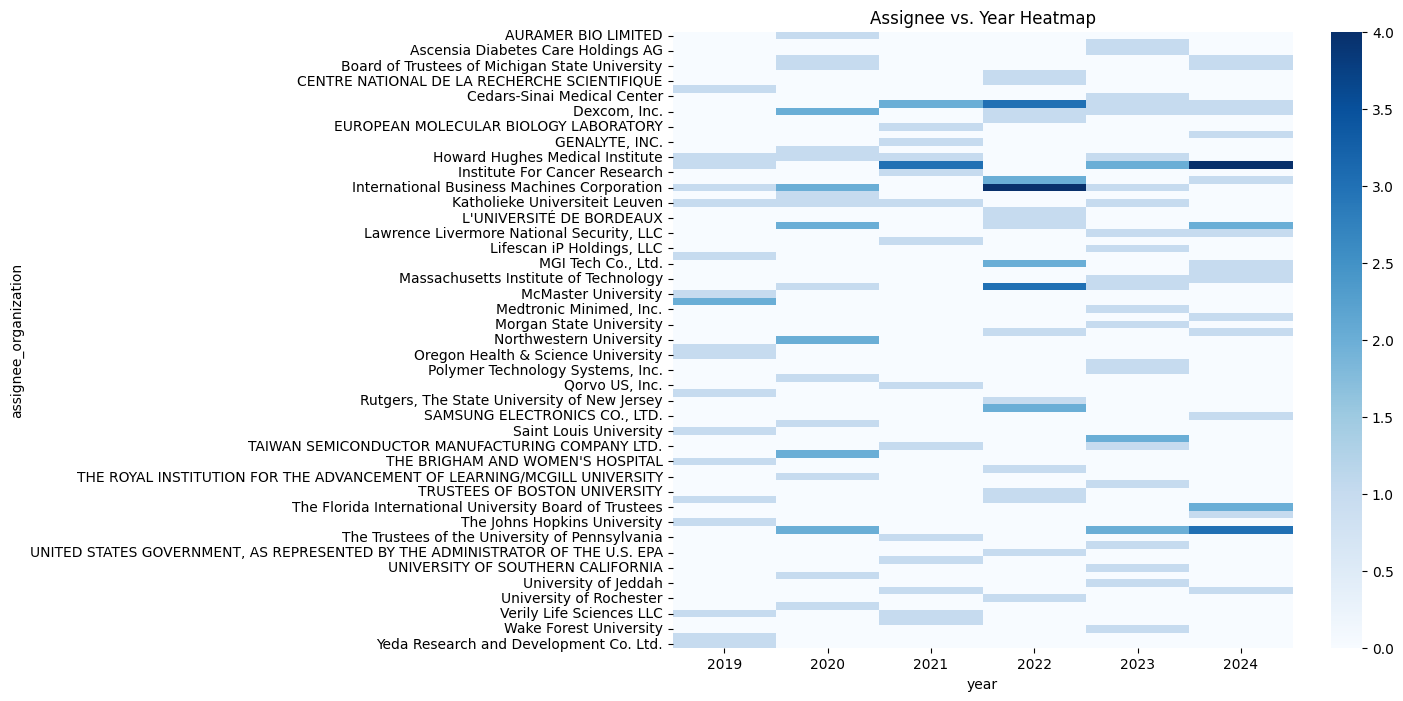

In [3]:
# Example: Assignee vs Year
df_main['year'] = df_main['patent_date'].dt.year
df_merged = pd.merge(df_main[['patent_number', 'year']],
                     df_assignees, on='patent_number', how='left')

pivot_assignee_year = df_merged.pivot_table(
    index='assignee_organization',
    columns='year',
    values='patent_number',
    aggfunc='count',
    fill_value=0
)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_assignee_year, cmap='Blues', annot=False)
plt.title("Assignee vs. Year Heatmap")
plt.show()


In [4]:
import plotly.express as px

# Count how many distinct inventors per country
country_counts = df_inventors.groupby('inventor_country')['patent_number'].nunique().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts,
                    locations='country',  # column name
                    locationmode='country names',
                    color='count',
                    title="Inventor Country Distribution",
                    color_continuous_scale='Blues')
fig.show()

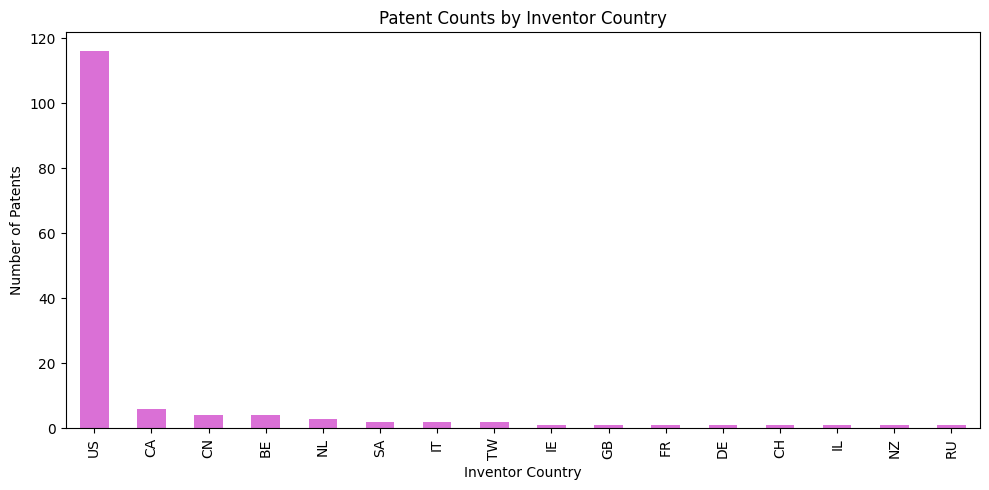

In [6]:
inventor_country_counts = df_inventors.groupby('inventor_country')['patent_number'].nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
inventor_country_counts.plot(kind='bar', color='orchid')
plt.xlabel("Inventor Country")
plt.ylabel("Number of Patents")
plt.title("Patent Counts by Inventor Country")
plt.tight_layout()
plt.show()

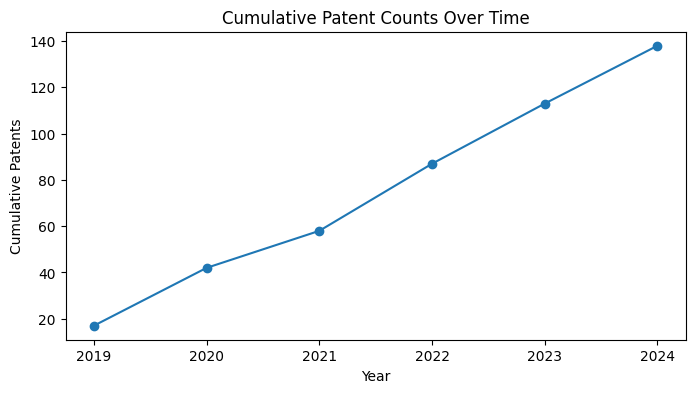

In [5]:
df_main['year'] = df_main['patent_date'].dt.year
df_year = df_main.groupby('year').size().reset_index(name='count')
df_year['cumulative'] = df_year['count'].cumsum()

plt.figure(figsize=(8,4))
plt.plot(df_year['year'], df_year['cumulative'], marker='o')
plt.title("Cumulative Patent Counts Over Time")
plt.xlabel("Year")
plt.ylabel("Cumulative Patents")
plt.show()


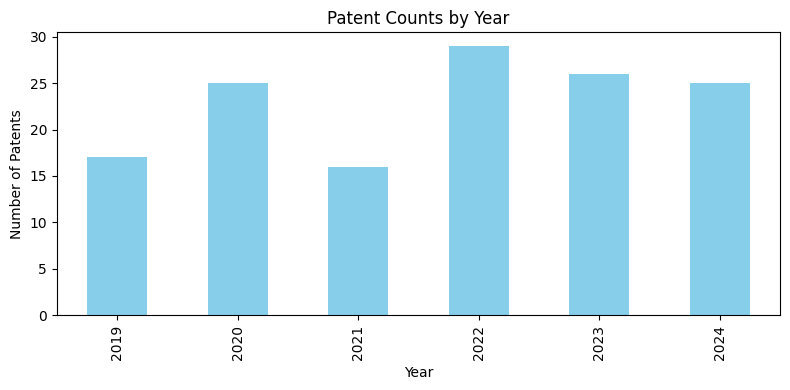

In [8]:
import matplotlib.pyplot as plt

# Create a column for year
df_main['year'] = df_main['patent_date'].dt.year

# Count patents per year
patents_per_year = df_main.groupby('year').size()

plt.figure(figsize=(8, 4))
patents_per_year.plot(kind='bar', color='skyblue')
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("Patent Counts by Year")
plt.tight_layout()
plt.show()


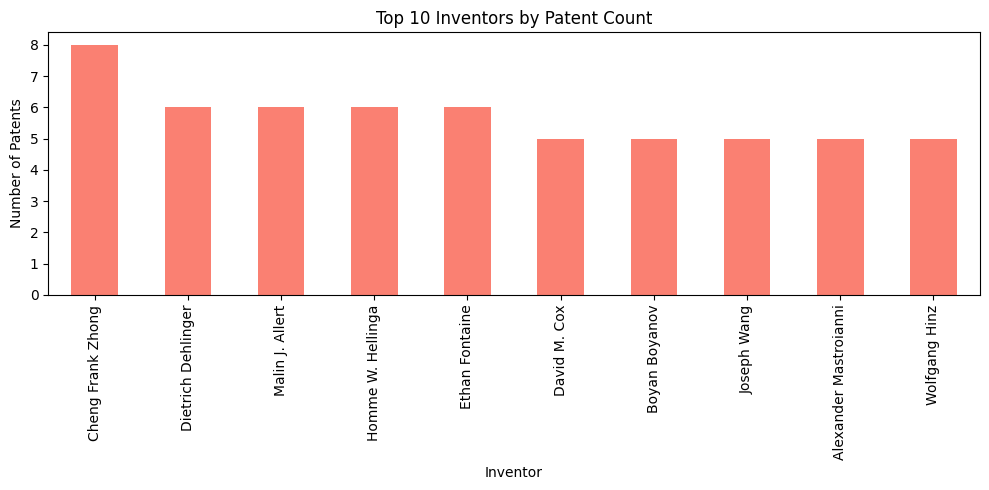

In [9]:
# Count patents per inventor (combining first and last names)
df_inventors['full_name'] = df_inventors['inventor_first_name'].str.strip() + " " + df_inventors['inventor_last_name'].str.strip()
top_inventors = df_inventors.groupby('full_name')['patent_number'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_inventors.plot(kind='bar', color='salmon')
plt.xlabel("Inventor")
plt.ylabel("Number of Patents")
plt.title("Top 10 Inventors by Patent Count")
plt.tight_layout()
plt.show()


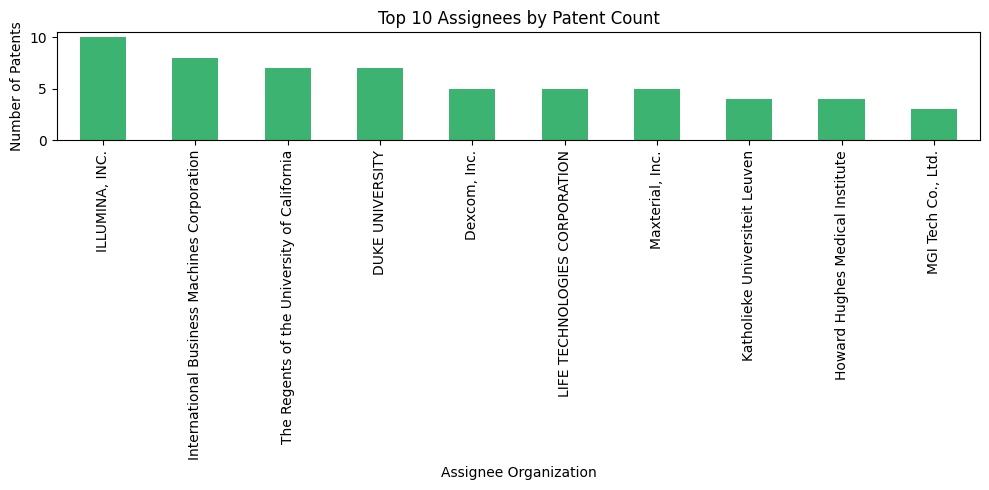

In [10]:
top_assignees = df_assignees.groupby('assignee_organization')['patent_number'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_assignees.plot(kind='bar', color='mediumseagreen')
plt.xlabel("Assignee Organization")
plt.ylabel("Number of Patents")
plt.title("Top 10 Assignees by Patent Count")
plt.tight_layout()
plt.show()

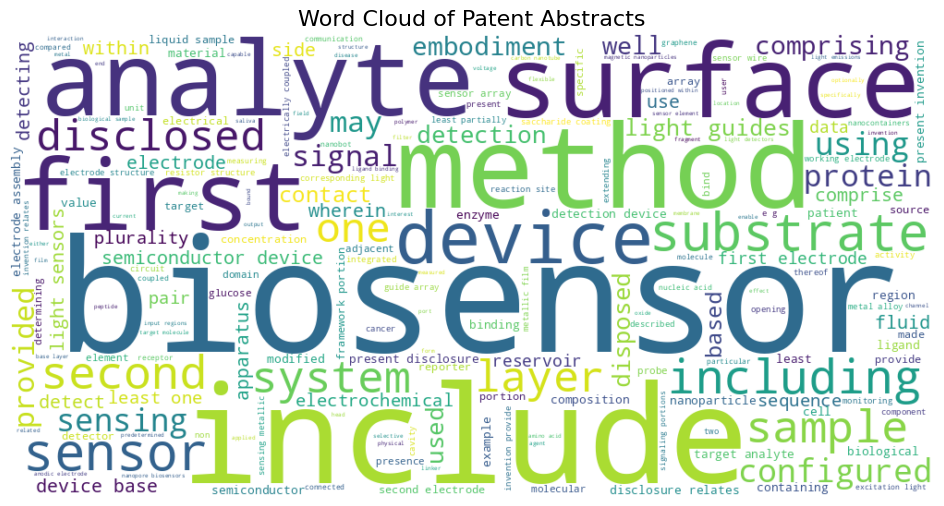

In [11]:
from wordcloud import WordCloud

all_abstracts = " ".join(df_main['patent_abstract'].dropna().tolist())
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(all_abstracts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Patent Abstracts", fontsize=16)
plt.show()

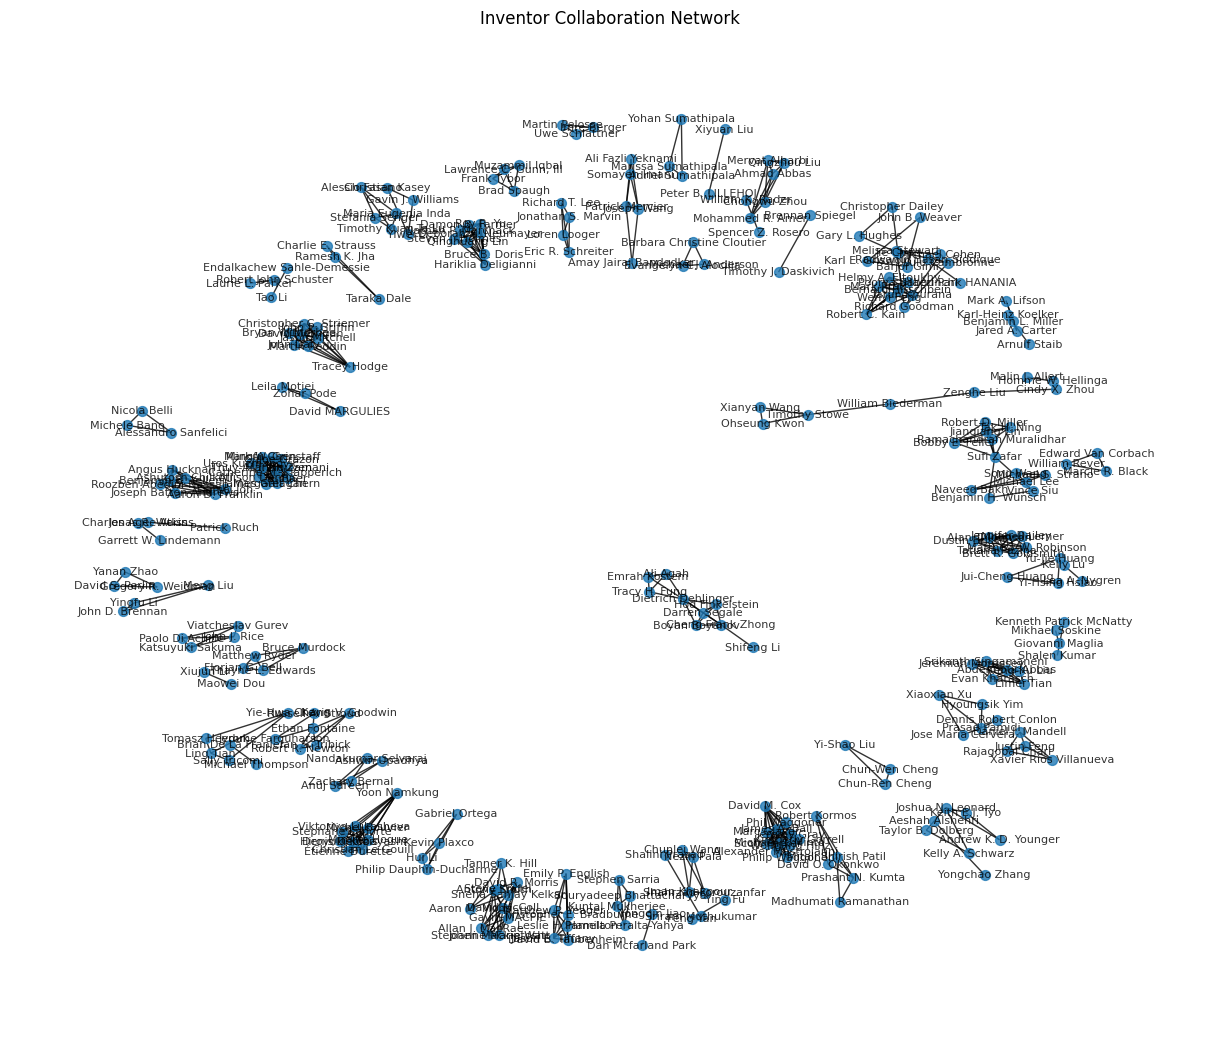

In [12]:
import networkx as nx

# Build an empty graph
G = nx.Graph()

# Group by patent to get list of inventors for each patent
grouped = df_inventors.groupby('patent_number')['full_name'].apply(list)

# For each patent, add edges between all pairs of inventors
for inventors in grouped:
    for i in range(len(inventors)):
        for j in range(i+1, len(inventors)):
            G.add_edge(inventors[i], inventors[j])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, alpha=0.8)
plt.title("Inventor Collaboration Network")
plt.show()

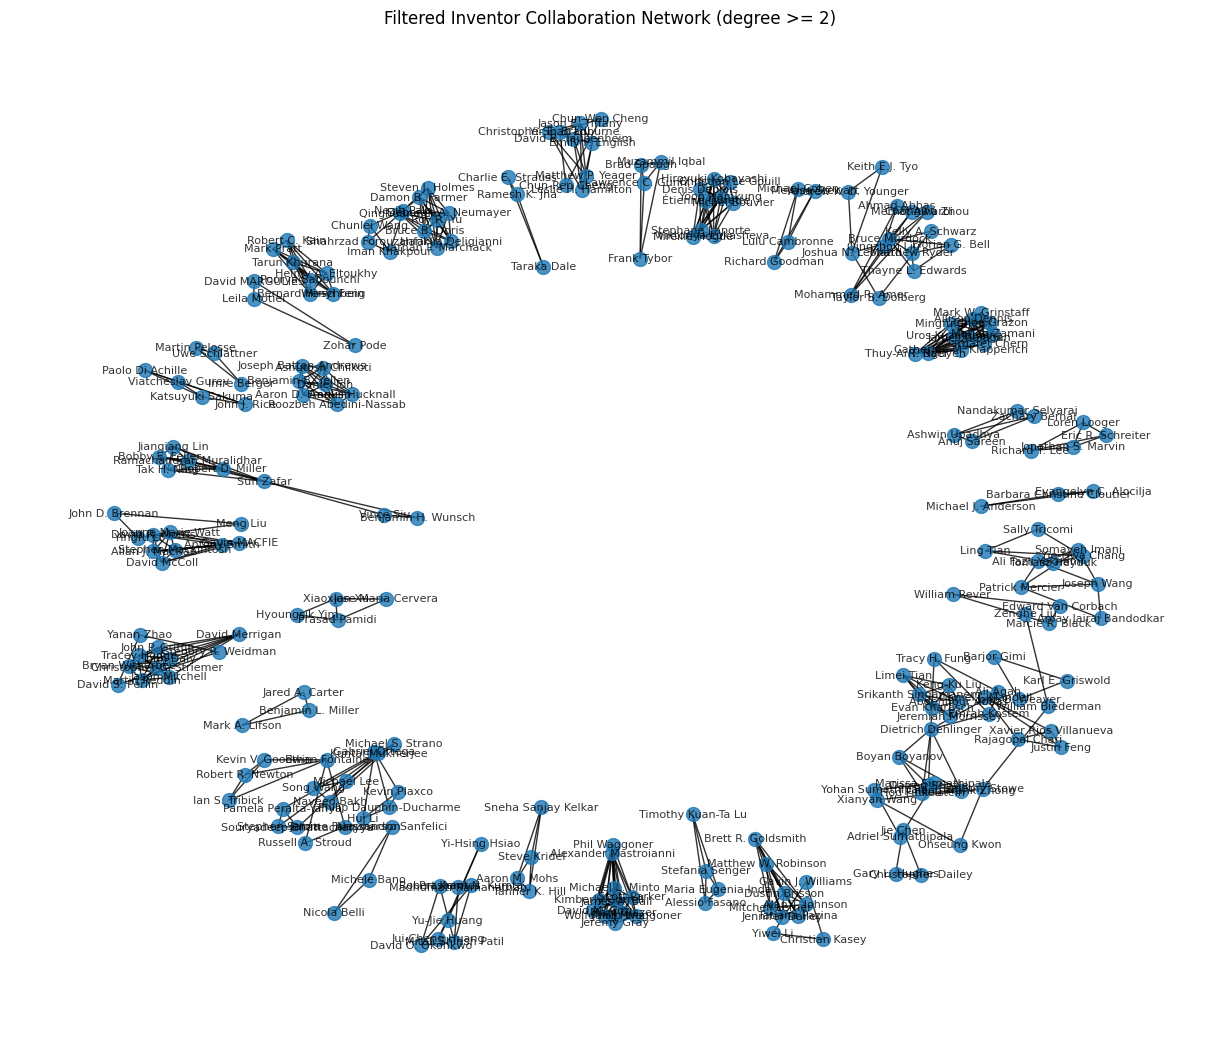

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Suppose G is your inventor collaboration graph
# 1) Compute the degree of each node (how many edges it has)
degrees = dict(G.degree())

# 2) Filter nodes that have degree >= 2
filtered_nodes = [n for n, deg in degrees.items() if deg >= 2]

# 3) Induce a subgraph containing only these nodes
H = G.subgraph(filtered_nodes).copy()

# 4) Plot the subgraph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, k=0.2)
nx.draw(H, pos, with_labels=True, node_size=100, font_size=8, alpha=0.8)
plt.title("Filtered Inventor Collaboration Network (degree >= 2)")
plt.show()

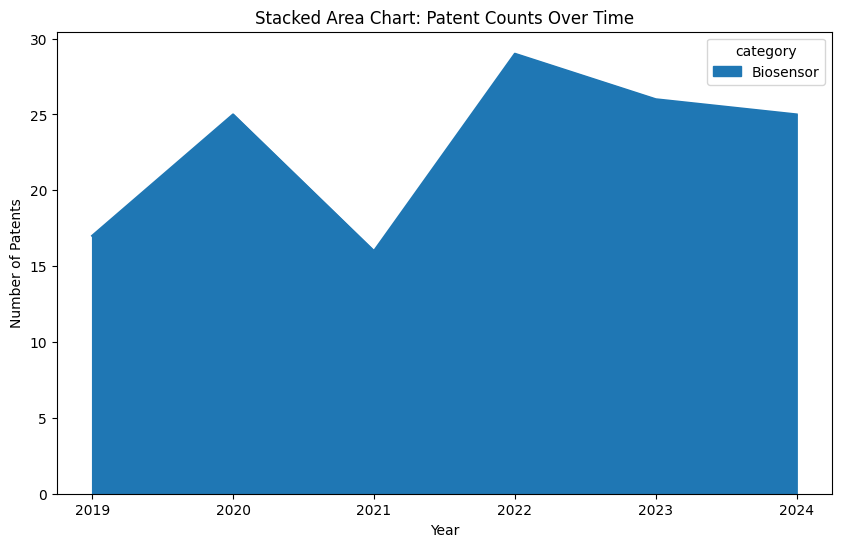

In [15]:
# Example: Creating a simple 'category' column based on keywords in the patent title (for demonstration)
def classify_patent(title):
    if "biosensor" in title.lower():
        return "Biosensor"
    else:
        return "Other"

df_main['category'] = df_main['patent_title'].apply(classify_patent)
df_main['year'] = df_main['patent_date'].dt.year

# Create a pivot table: counts of patents per year per category
pivot_table = df_main.groupby(['year', 'category']).size().unstack(fill_value=0)
pivot_table.plot.area(figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("Stacked Area Chart: Patent Counts Over Time")
plt.show()


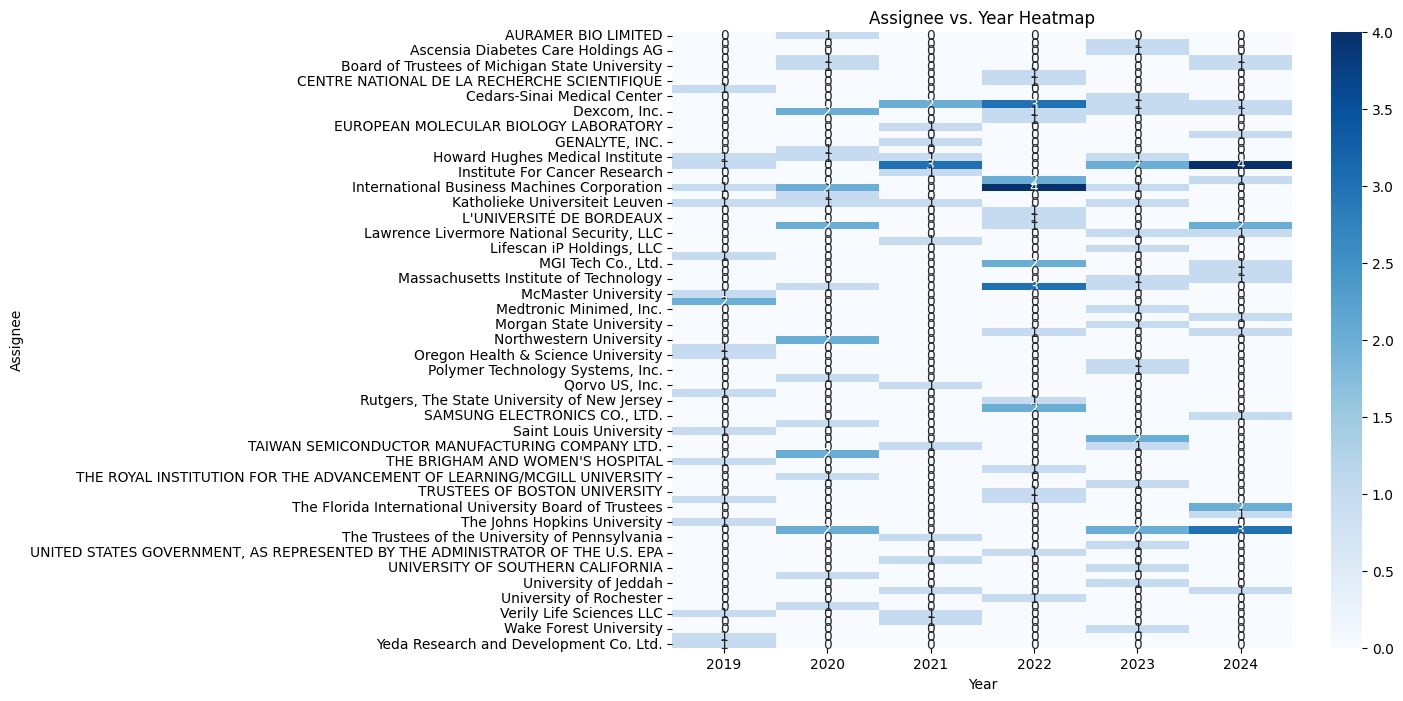

In [17]:
df_main['year'] = df_main['patent_date'].dt.year
# Merge main data with assignees (ensuring each patent is associated with its assignees)
df_merged = pd.merge(df_main[['patent_number', 'year']],
                     df_assignees, on='patent_number', how='left')

pivot_assignee_year = df_merged.pivot_table(
    index='assignee_organization',
    columns='year',
    values='patent_number',
    aggfunc='count',
    fill_value=0
)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_assignee_year, cmap='Blues', annot=True, fmt="d")
plt.title("Assignee vs. Year Heatmap")
plt.xlabel("Year")
plt.ylabel("Assignee")
plt.show()


In [19]:
import plotly.express as px

# Count distinct patents per inventor country
country_counts = df_inventors.groupby('inventor_country')['patent_number'].nunique().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts,
                    locations='country',
                    locationmode='country names',
                    color='count',
                    title="Inventor Country Distribution",
                    color_continuous_scale='Blues')
fig.show()


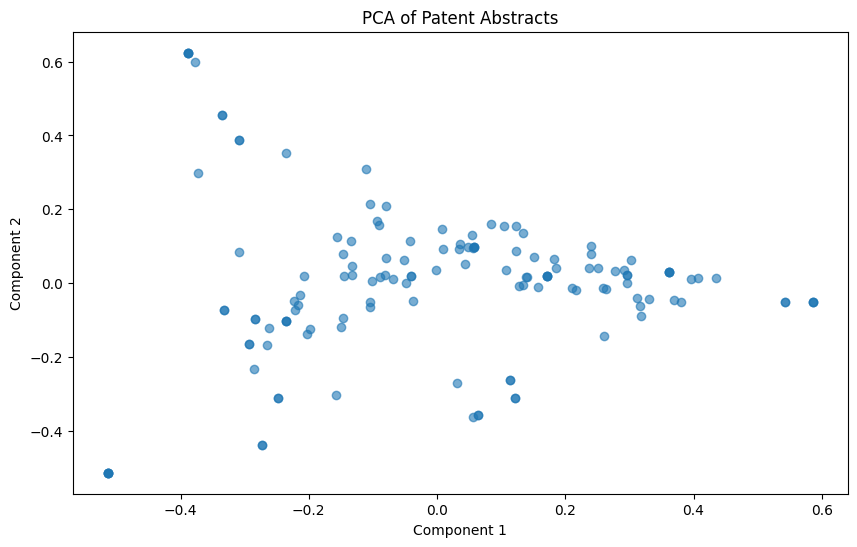

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Combine all abstracts (ensure you drop NaNs)
abstracts = df_main['patent_abstract'].dropna().tolist()

# Vectorize abstracts
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(abstracts)

# Reduce dimensions with PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X.toarray())

# Create a DataFrame for plotting
df_topics = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
plt.figure(figsize=(10, 6))
plt.scatter(df_topics['Component 1'], df_topics['Component 2'], alpha=0.6)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of Patent Abstracts")
plt.show()


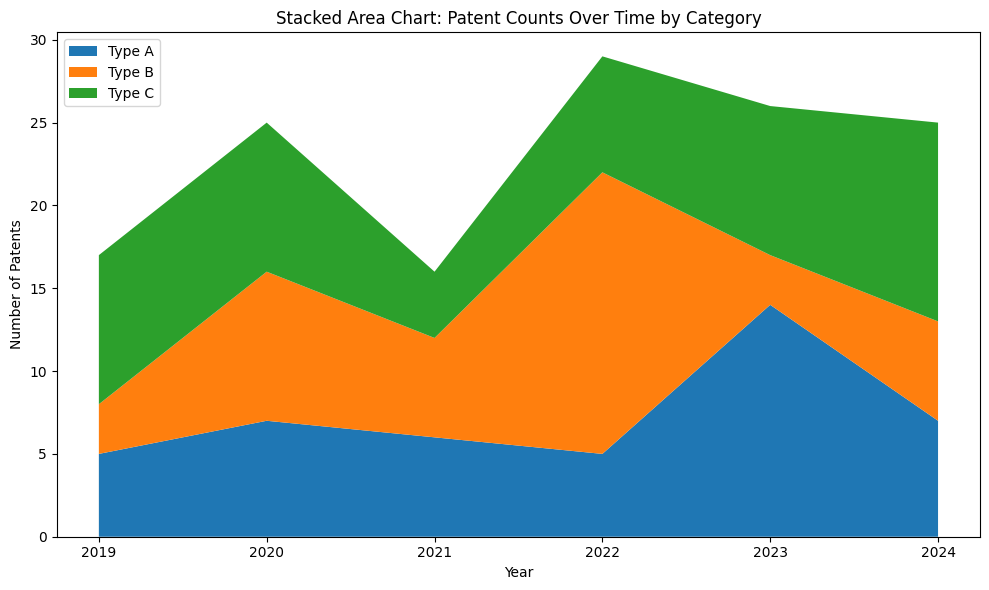

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# For demonstration, we create a dummy category column.
# In practice, you’d use real categorization logic.
np.random.seed(42)
possible_categories = ['Type A', 'Type B', 'Type C']
df_main['category'] = np.random.choice(possible_categories, size=len(df_main))

# Ensure we have a 'year' column:
df_main['year'] = df_main['patent_date'].dt.year

# Create pivot table: rows are years, columns are categories.
pivot_table = df_main.groupby(['year', 'category']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
# Stacked area plot using Matplotlib's stackplot:
years = pivot_table.index.values
categories = pivot_table.columns
data = [pivot_table[cat].values for cat in categories]

plt.stackplot(years, *data)
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("Stacked Area Chart: Patent Counts Over Time by Category")
plt.legend(categories, loc='upper left')
plt.tight_layout()
plt.show()


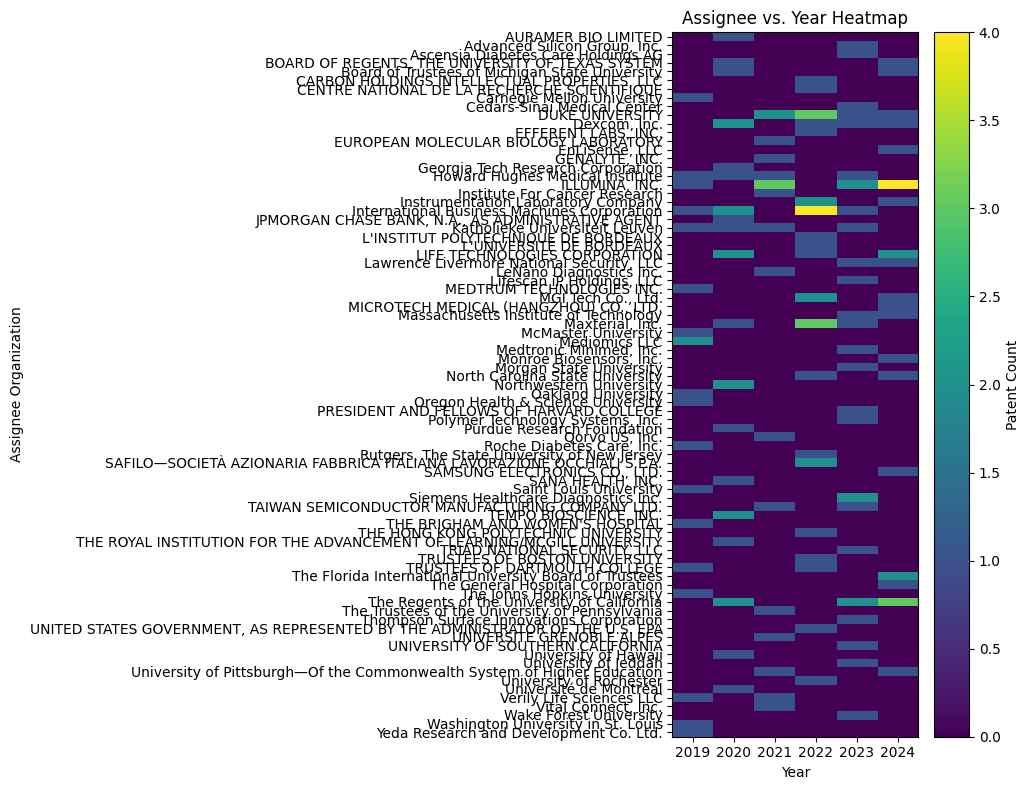

In [22]:
# Merge main and assignee data to get the year for each assignee entry.
df_main['year'] = df_main['patent_date'].dt.year
df_merged = pd.merge(df_main[['patent_number', 'year']], df_assignees, on='patent_number', how='left')

# Create pivot table: rows are assignee organizations, columns are years.
pivot_assignee_year = df_merged.pivot_table(
    index='assignee_organization',
    columns='year',
    values='patent_number',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(10, 8))
plt.imshow(pivot_assignee_year, aspect='auto', interpolation='nearest')
plt.colorbar(label="Patent Count")
plt.xticks(ticks=range(len(pivot_assignee_year.columns)), labels=pivot_assignee_year.columns)
plt.yticks(ticks=range(len(pivot_assignee_year.index)), labels=pivot_assignee_year.index)
plt.title("Assignee vs. Year Heatmap")
plt.xlabel("Year")
plt.ylabel("Assignee Organization")
plt.tight_layout()
plt.show()


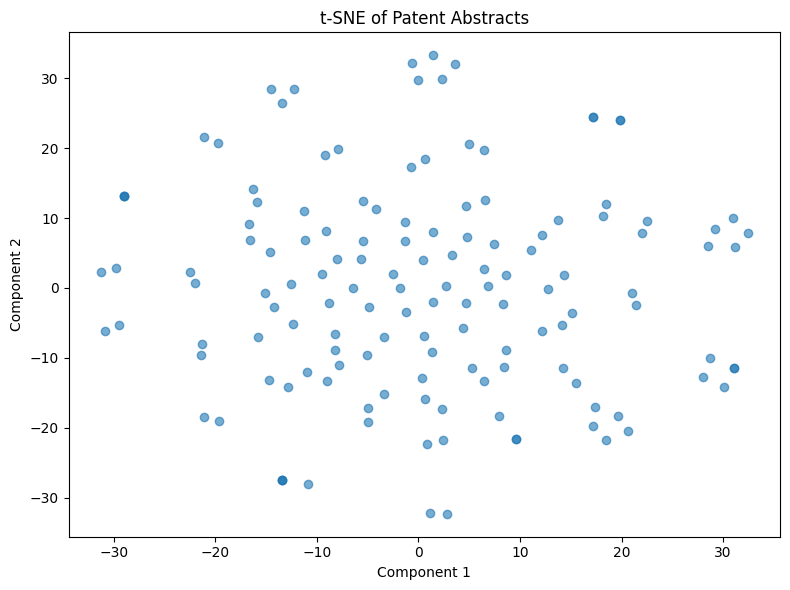

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Prepare text data (drop missing abstracts)
abstracts = df_main['patent_abstract'].dropna().tolist()

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = vectorizer.fit_transform(abstracts)

# Dimensionality reduction to 50 components using SVD
svd = TruncatedSVD(n_components=50, random_state=42)
svd_matrix = svd.fit_transform(tfidf_matrix)

# Further reduce dimensions to 2 using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(svd_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)
plt.title("t-SNE of Patent Abstracts")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


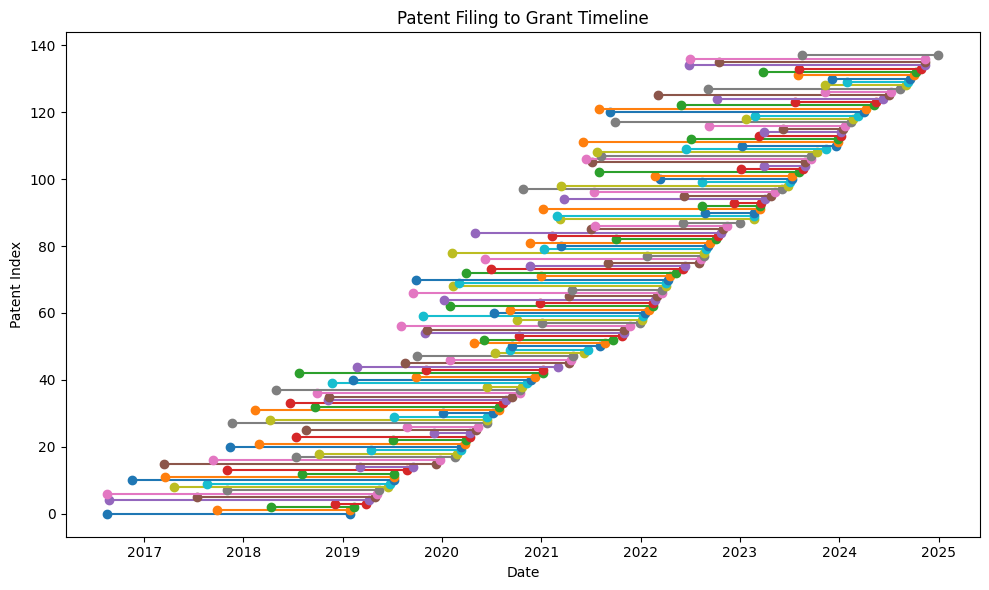

In [25]:
# For demonstration, we create a dummy filing date column
df_main['filing_date'] = df_main['patent_date'] - pd.to_timedelta(np.random.randint(100, 1000, size=len(df_main)), unit='D')

plt.figure(figsize=(10, 6))
for idx, row in df_main.iterrows():
    plt.plot([row['filing_date'], row['patent_date']], [idx, idx], marker='o')
plt.xlabel("Date")
plt.ylabel("Patent Index")
plt.title("Patent Filing to Grant Timeline")
plt.tight_layout()
plt.show()


In [26]:
!pip install bar_chart_race

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 3.7 MB/s eta 0:00:00


In [27]:
import bar_chart_race as bcr

# Build a DataFrame: rows are years, columns are assignee organizations,
# and the values are cumulative patent counts.
df_main['year'] = df_main['patent_date'].dt.year
df_merged = pd.merge(df_main[['patent_number', 'year']], df_assignees, on='patent_number', how='left')

assignee_year = df_merged.groupby(['year', 'assignee_organization']).size().unstack(fill_value=0)
# Compute cumulative sum over the years
assignee_cumsum = assignee_year.cumsum()

bcr.bar_chart_race(
    df=assignee_cumsum,
    filename=None,  # Set to a filename to save the animation
    title="Top Assignees Patent Counts Over Time"
)


/usr/local/lib/python3.11/dist-packages/bar_chart_race/_make_chart.py:889: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/usr/local/lib/python3.11/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning:

Glyph 127 () missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning:

Glyph 128 (\x80) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning:

Glyph 129 (\x81) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning:

Glyph 130 (\x82) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning:

Glyph 131 (\x83) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/bar_chart_race/_make_chart.py:284: UserWarning:


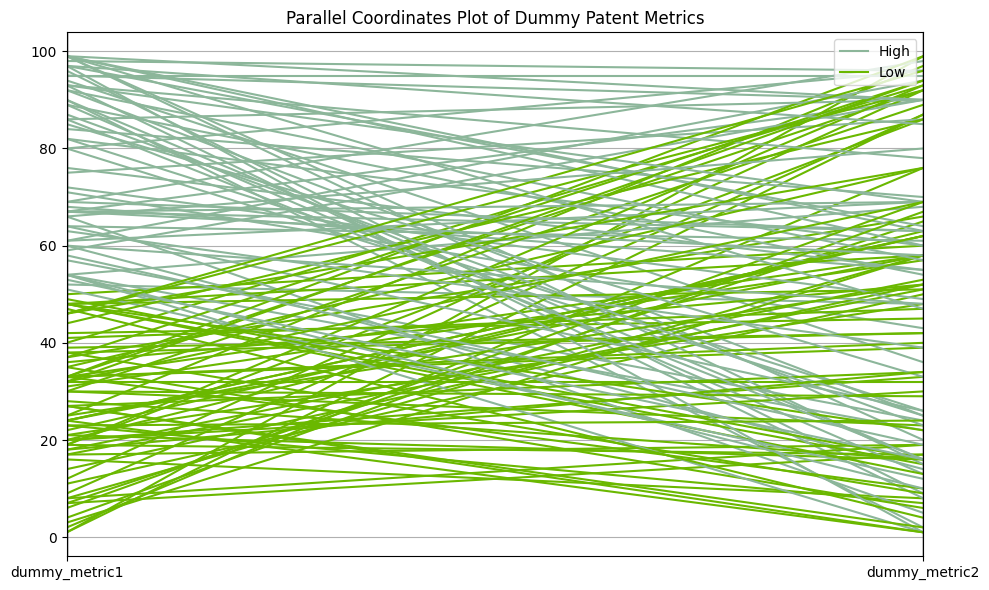

In [28]:
from pandas.plotting import parallel_coordinates

# Create dummy numeric features for demonstration
df_main['dummy_metric1'] = np.random.randint(1, 100, size=len(df_main))
df_main['dummy_metric2'] = np.random.randint(1, 100, size=len(df_main))

# For clarity, assign a dummy category (e.g., based on dummy_metric1)
df_main['dummy_category'] = np.where(df_main['dummy_metric1'] > 50, 'High', 'Low')

plt.figure(figsize=(10, 6))
parallel_coordinates(df_main[['dummy_metric1', 'dummy_metric2', 'dummy_category']], class_column='dummy_category')
plt.title("Parallel Coordinates Plot of Dummy Patent Metrics")
plt.tight_layout()
plt.show()


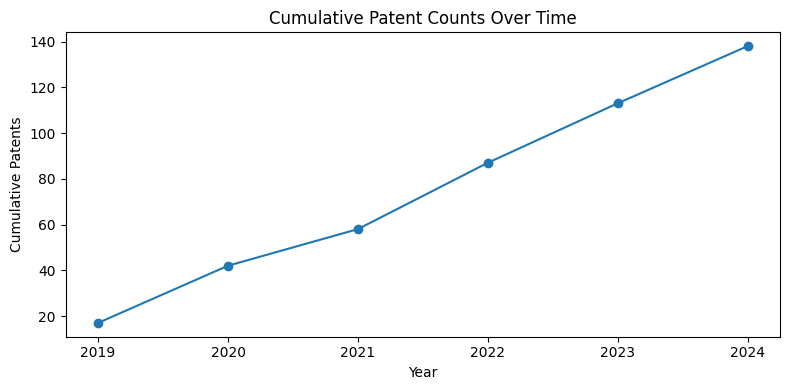

In [29]:
df_year = df_main.groupby('year').size().reset_index(name='count')
df_year['cumulative'] = df_year['count'].cumsum()

plt.figure(figsize=(8, 4))
plt.plot(df_year['year'], df_year['cumulative'], marker='o')
plt.title("Cumulative Patent Counts Over Time")
plt.xlabel("Year")
plt.ylabel("Cumulative Patents")
plt.tight_layout()
plt.show()


In [ ]:
grouped = df_inventors.groupby('patent_number')[['inventor_first_name', 'inventor_last_name']].apply(
    lambda x: x['inventor_first_name'].str.strip() + " " + x['inventor_last_name'].str.strip()
).reset_index(name='full_names')


In [33]:
import plotly.graph_objects as go

# Build the co-inventor network (using the complete inventor collaboration graph, G, built earlier).
import networkx as nx

# Rebuild G if not already available
G = nx.Graph()
grouped_inventors = df_inventors.groupby('patent_number')[['inventor_first_name', 'inventor_last_name']]
for pn, group in grouped_inventors:
    # Combine first and last names
    names = group.apply(lambda row: f"{row['inventor_first_name'].strip()} {row['inventor_last_name'].strip()}", axis=1).tolist()
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            G.add_edge(names[i], names[j])

# Filter out nodes with degree < 1 (for clarity)
filtered_nodes = [n for n, deg in dict(G.degree()).items() if deg >= 1]
H = G.subgraph(filtered_nodes).copy()

# Create a sorted list of nodes
nodes = sorted(list(H.nodes()))
N = len(nodes)

# Build adjacency matrix
adj_matrix = [[0]*N for _ in range(N)]
for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
        if H.has_edge(u, v):
            adj_matrix[i][j] = 1

# Prepare data for Plotly's chord-like visualization using a Sankey diagram approach.
# Here we will split each inventor into two sets (source and target are the same) to mimic chord flows.
node_labels = nodes
source = []
target = []
value = []

for i in range(N):
    for j in range(i+1, N):
        if adj_matrix[i][j]:
            # Add both directions
            source.append(i)
            target.append(j)
            value.append(1)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=10,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])
fig.update_layout(title_text="Simplified Co-Inventor Chord Diagram (using Sankey)", font_size=10)
fig.show()


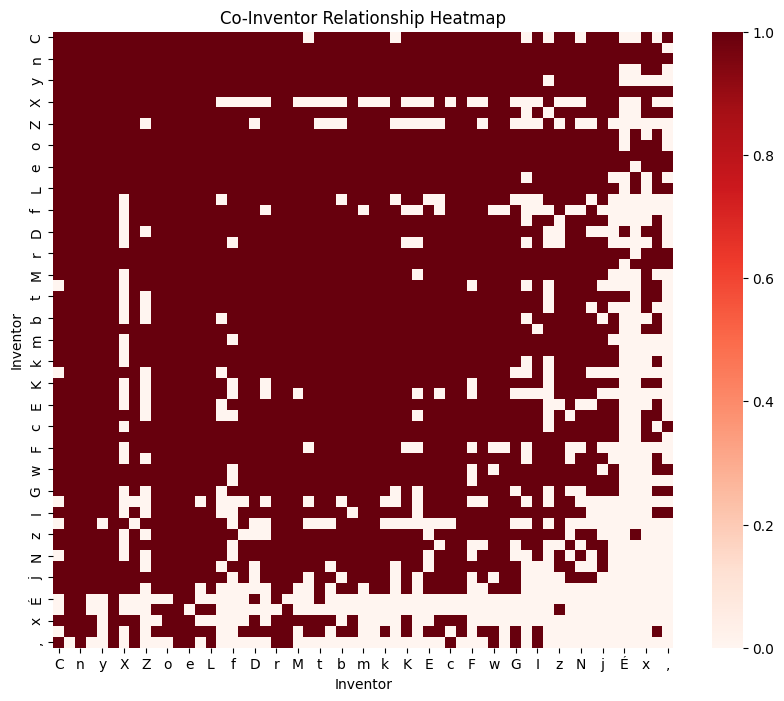

In [35]:
# First, build the co-inventor network (assuming G is your collaboration graph from earlier)
import networkx as nx

# Build the full collaboration graph
G = nx.Graph()
grouped_inventors = df_inventors.groupby('patent_number')[['inventor_first_name', 'inventor_last_name']]

for _, row in grouped.iterrows():
    inventors = row['full_names']
    for i in range(len(inventors)):
        for j in range(i+1, len(inventors)):
            G.add_edge(inventors[i], inventors[j])

# Now create an adjacency matrix from the graph
nodes = list(G.nodes())
adj_matrix = nx.to_pandas_adjacency(G, nodelist=nodes)

# Plot a heatmap of the adjacency matrix (simpler than a chord diagram)
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix, cmap='Reds')
plt.title("Co-Inventor Relationship Heatmap")
plt.xlabel("Inventor")
plt.ylabel("Inventor")
plt.show()


In [36]:
def classify(title, abstract):
    # Dummy example: classify based on presence of a keyword.
    if "biosensor" in title.lower() or "biosensor" in abstract.lower():
        return "Biosensor"
    else:
        return "Other"

df_main['category'] = df_main.apply(lambda row: classify(row['patent_title'], row['patent_abstract']), axis=1)
df_exploded = df_main.explode('category').reset_index(drop=True)


In [37]:
# Example classification snippet (pseudo-code)
df_main['category'] = df_main.apply(lambda row: classify(row['patent_title'], row['patent_abstract']), axis=1)
df_exploded = df_main.explode('category').reset_index(drop=True)

# Then you can do:
pivot_table = df_exploded.pivot_table(
    index='year',
    columns='category',
    values='patent_number',
    aggfunc='count',
    fill_value=0
)
